In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import os
import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR
from pykeen.pipeline import pipeline
from pykeen import predict
from statistics import mean, median
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from itertools import chain
from pathlib import Path
from rich import print

from utils import prepare_for_visualization

## Settings

In [3]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

## Loading data

In [4]:
dataset = Nations()

g = nx.DiGraph()
g.add_edges_from([(h, t, {"title": r}) for h, r, t in dataset.training.triples])

Reconstructing all label-based triples. This is expensive and rarely needed.


## Visualization

In [7]:
nt = Network("500px", "500px", directed=True, notebook=True)
nt.inherit_edge_colors(False)
nt.from_nx(g)
nt.toggle_physics(False)
nt.show("basic.html")

basic.html


In [8]:
_list_nodes = list(g.nodes)
@interact
def visualize(nodes=widgets.SelectMultiple(options=list(g.nodes), value=[_list_nodes[0]]), k=[0, 1,2,3]):
    filtered = set(chain(*[list(nx.single_source_shortest_path_length(g, n, cutoff=k)) for n in nodes]))
    print(filtered)
    subgraph = nx.subgraph_view(g, filter_node=lambda x: x in filtered)
    nt = Network("500px", "500px", directed=True, notebook=True)
    nt.inherit_edge_colors(False)
    nt.from_nx(subgraph)
    nt.toggle_physics(True)
    display(nt.show("basic.html"))
    

interactive(children=(SelectMultiple(description='nodes', index=(0,), options=('brazil', 'china', 'cuba', 'pol…

## EDA

In [9]:
data = []
for subset_name in ["training", "validation", "testing"]:
    subset_metrics = {"subset": subset_name}
    subset = dataset.__getattribute__(subset_name)
    triples = subset.triples
    subset_metrics["num_triples"] = len(triples)
    subset_metrics["num_entities"] = len(np.unique(triples[:, [0,2]]))
    subset_metrics["num_relations"] = len(np.unique(triples[:, 1]))
    data.append(subset_metrics)

pd.DataFrame(data)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


,subset,num_triples,num_entities,num_relations
0,training,1592,14,55
1,validation,199,14,45
2,testing,201,14,41


In [41]:
metrics = {}


metrics["n_connected_components"] = nx.number_connected_components(g.to_undirected())
metrics["mean_size_of_connected_components"] = mean(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["median_size_of_connected_components"] = median(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["density"] = nx.density(g)
metrics["number_of_selfloops"] = nx.number_of_selfloops(g)
# metrics["degree_centrality"] = nx.degree_centrality(g)
# metrics["in_degree_centrality"] = nx.in_degree_centrality(g)
# metrics["out_degree_centrality"] = nx.out_degree_centrality(g)
# metrics["closeness_centrality"] = nx.closeness_centrality(g)
metrics["average_clustering"] = nx.average_clustering(g)

pd.DataFrame({"training":metrics})

,training
average_clustering,1.00000
density,1.00000
mean_size_of_connected_components,14.00000
median_size_of_connected_components,14.00000
n_connected_components,1.00000
number_of_selfloops,0.00000


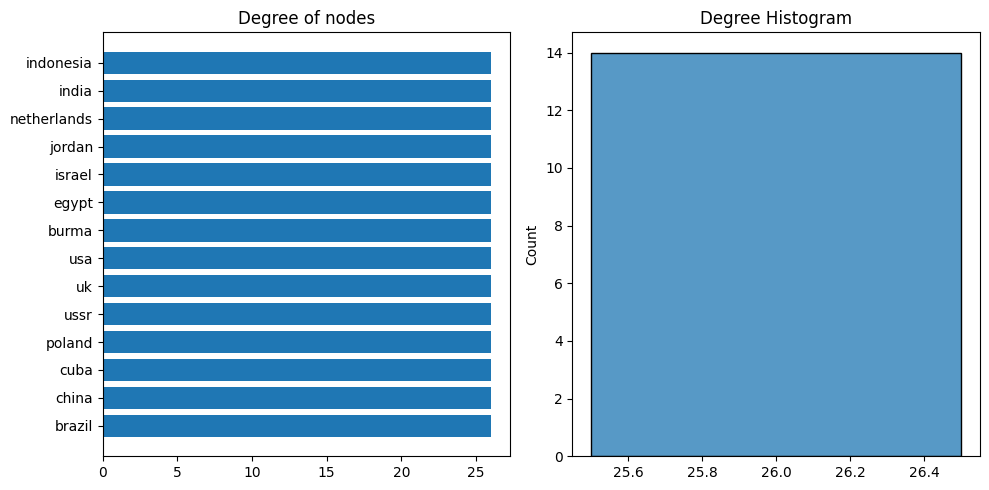

In [27]:
x, y = zip(*g.degree())

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].set_title("Degree of nodes")
axes[0].barh(y=x, width=y)
axes[1].set_title("Degree Histogram")
sns.histplot([d for n, d in g.degree()], ax=axes[1])
plt.tight_layout()

## Training 

In [35]:
result = pipeline(
    dataset="Nations",
    model="TransE",
    model_kwargs={"embedding_dim": 64},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    random_seed=123,
)

No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/201 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds


In [39]:
save_location = Path("results")
save_location.mkdir(exist_ok=True)
result.save_to_directory(save_location)
print(f"Saved: {os.listdir(save_location)}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/home/albert/anaconda3/envs/22-multiple-graph-inference/lib/python3.10/site-packages/pykeen/datasets/nations/train.txt") to file:///home/albert/dev/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/kg-workshop-23/results


Saved: ['metadata.json', 'results.json', 'training_triples', 'trained_model.pkl']

## Metrics

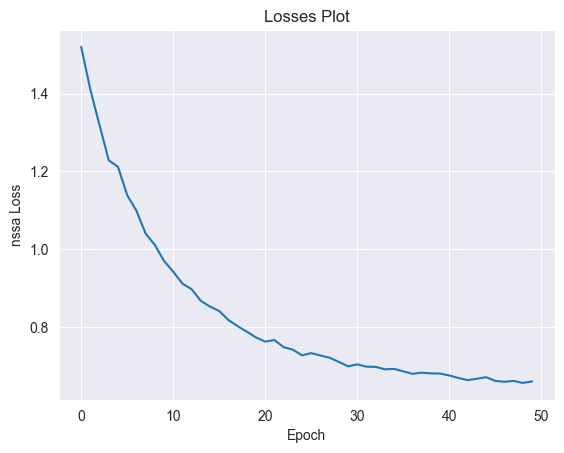

In [44]:
result.plot_losses()
plt.show()

In [48]:
metrics = result.metric_results.to_df()

In [49]:
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,arithmetic_mean_rank,3.66667
14,both,realistic,median_absolute_deviation,1.48260
23,both,realistic,adjusted_arithmetic_mean_rank,0.81889
32,both,realistic,z_inverse_harmonic_mean_rank,-2.34949
41,both,realistic,z_arithmetic_mean_rank,6.52849
50,both,realistic,harmonic_mean_rank,2.83433
59,both,realistic,inverse_harmonic_mean_rank,0.35282
68,both,realistic,adjusted_geometric_mean_rank_index,0.12462
77,both,realistic,inverse_geometric_mean_rank,0.31634
86,both,realistic,variance,5.61028


## Embeddings visualization

In [50]:
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14, 64)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(55, 64)
    )
  )
  (weight_regularizers): ModuleList()
)

In [51]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]

In [52]:
prepare_for_visualization(embeddings.detach().numpy(), labels, Path("logs/nations"))

In [53]:
!tensorboard --logdir=logs/nations

2023-06-13 19:28:01.231401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
